### Programming Assignment 5
# **Linear Regression**

AJ Dave A. Obis and Juan Francis C. Tuatis

## Import the libraries to be used


In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# **General Guidelines**
## 1. Load and perform exploratory data analysis

In [14]:
data = pd.read_csv("cyber_attacks(in).csv")

# Transform the data to DataFrame
data_df = pd.DataFrame(data)

# Print the first few rows of the DataFrame
data_df.head()


,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


### Check the Dataset Contents

In [15]:
# Number of rows and columns in the DataFrame
print("Number of rows: ", data_df.shape[0])
print("Number of columns: ", data_df.shape[1])

Number of rows:  10000
Number of columns:  7


In [16]:
# Check if there are missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values:\n", + missing_values)

Missing values:
 protocol_type        0
duration           500
src_bytes          500
dst_bytes          500
num_packets          0
num_connections      0
attack_type          0
dtype: int64


Looking at the distribution of the dataset with missing values,

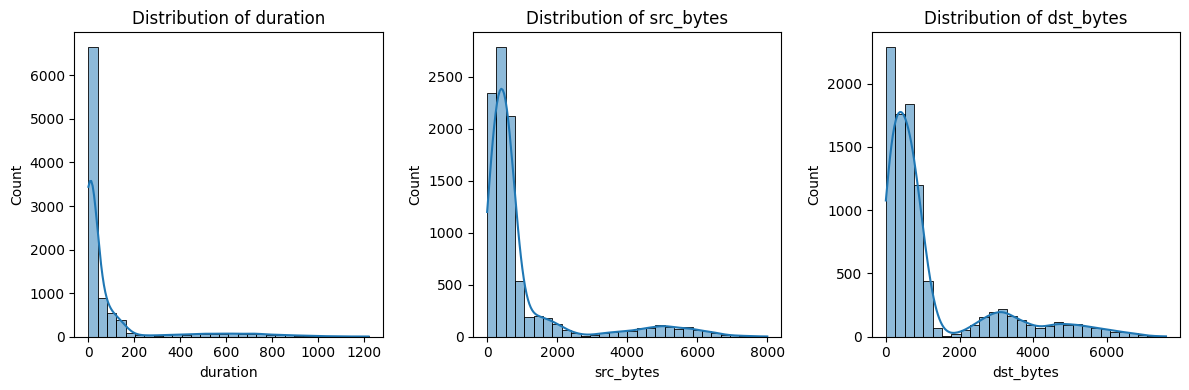

In [17]:
# Visualize distributions of affected numerical features
numerical_features = ['duration', 'src_bytes', 'dst_bytes']

# Plot histograms for missing value analysis
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

we can say that the data is right-skewed therefore highly variable.

### Attack Type Frequency

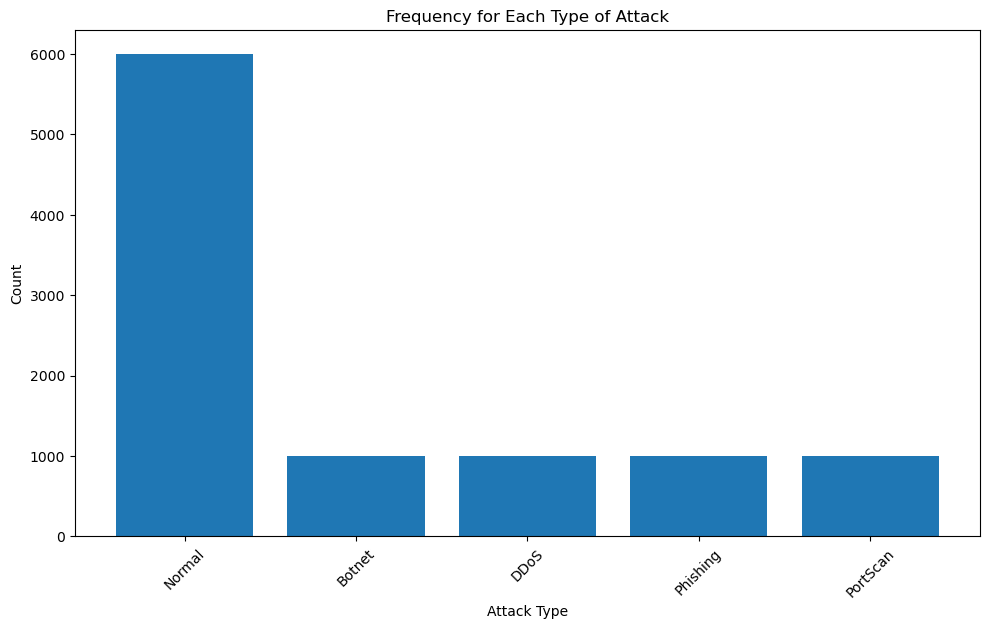

In [ ]:
attack_counts = data_df['attack_type'].value_counts().reset_index()
attack_counts.columns = ['attack_type', 'count']

# Plot the attack counts
plt.figure(figsize=(10,6))
plt.bar(attack_counts['attack_type'], attack_counts['count'])

plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title('Frequency for Each Type of Attack')

plt.xticks(rotation=45)
plt.show()

### 

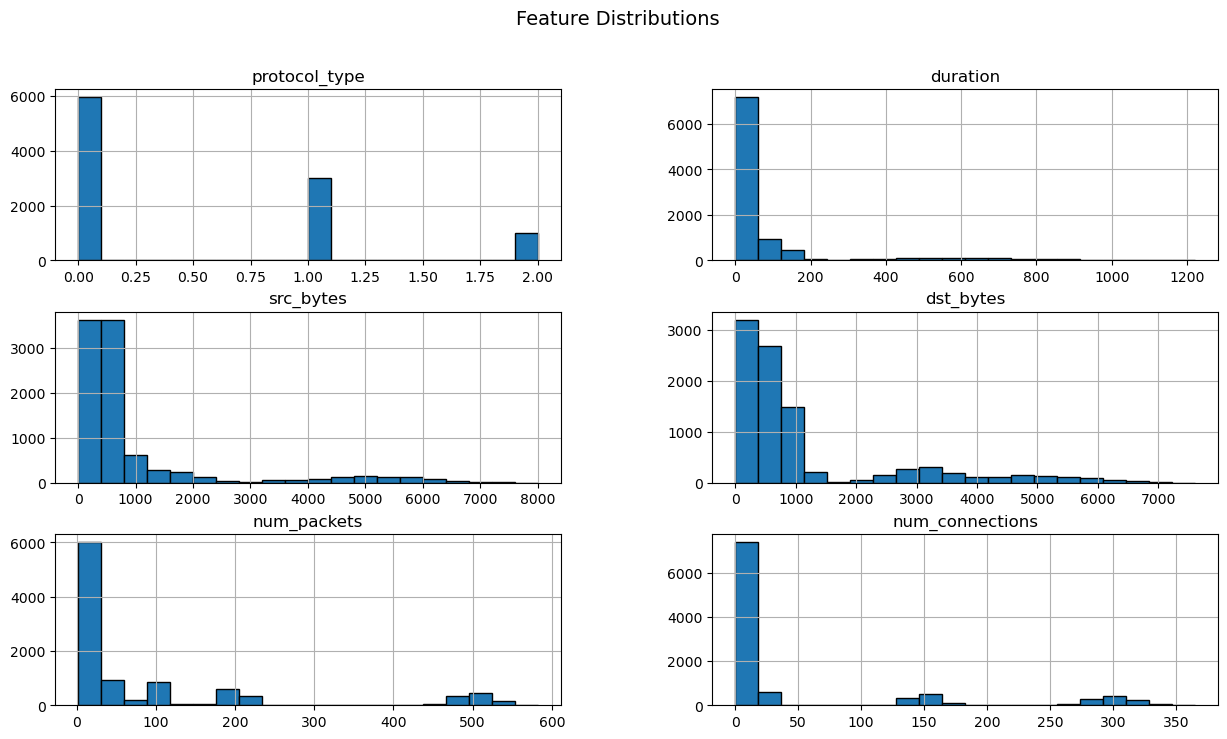

In [25]:
data_df.hist(figsize=(15, 8), bins=20, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

## 2. Perform data preprocessing.

### Handling missing values
To address the missing values from our EDA, we implemented median imputation which is effective for highly variable dataset and extreme values to avoid distortion

In [21]:
# Apply median imputation
imputer = SimpleImputer(strategy="median")
data_df[['duration', 'src_bytes', 'dst_bytes']] = imputer.fit_transform(data_df[['duration', 'src_bytes', 'dst_bytes']])

# show head
data_df.head()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,7.121187,500.910972,598.294521,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


In [22]:
# Check if there are still missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values:\n", + missing_values)

Missing values:
 protocol_type      0
duration           0
src_bytes          0
dst_bytes          0
num_packets        0
num_connections    0
attack_type        0
dtype: int64


### Encoding categorical variable/feature (eg. protocol_type)

In [23]:
# Display the unique values in the categorical column
print("Unique values in protocol_type:", data_df['protocol_type'].unique())

# Perform one-hot encoding on the protocol_type column
data_df = pd.get_dummies(data_df, columns=['protocol_type'], drop_first=True)

# Display the first few rows of the encoded dataset
print("\nDataset after one-hot encoding:")
print(data_df.head())

Unique values in protocol_type: [1 0 2]

Dataset after one-hot encoding:
    duration    src_bytes   dst_bytes  num_packets  num_connections  \
0  43.418651  1701.411601  201.794741           42               15   
1   8.587924   409.971403  710.745376           17                6   
2   4.386891   418.478693  559.457816           17                5   
3   7.121187   500.910972  598.294521           11                3   
4   1.061892   494.253699  572.459614           11                3   

  attack_type  protocol_type_1  protocol_type_2  
0      Botnet             True            False  
1      Normal             True            False  
2      Normal             True            False  
3      Normal            False            False  
4      Normal            False            False  


### Handle class imbalance

In [24]:
print(data_df['attack_type'].value_counts())

attack_type
Normal      6000
Botnet      1000
DDoS        1000
Phishing    1000
PortScan    1000
Name: count, dtype: int64


### Spliting the Train and Test Data
Split the data into training (70%) and testing (30%) sets.

In [27]:
y = data['attack_type']

X_train, X_test, y_train, y_test = train_test_split(data_df, y, test_size=0.3, random_state=14)